In [1]:
import torch
from encoder.encoders import DistributionEncoderTx
from generator.wormhole import WormholeGenerator
from datasets.mnist import MNISTDataset
from torch.utils.data import DataLoader
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [7]:
dataset = MNISTDataset(set_size=100, n_sets=1000)

In [8]:
dataloader = DataLoader(
    dataset,
    batch_size=16,
    shuffle=True,
)

In [9]:
in_dim = 28*28
latent_dim = 64
hidden_dim = 128
set_size = dataset.set_size
device = 'cuda'

enc = DistributionEncoderTx(in_dim, latent_dim, hidden_dim, set_size)
gen = WormholeGenerator(latent_dim, in_dim, hidden_dim, set_size)
optimizer = torch.optim.Adam(list(enc.parameters()) + list(gen.parameters()), lr=1e-3)
enc.to(device)
gen.to(device)

WormholeGenerator(
  (model): DistributionDecoderTx(
    (decoder): Sequential(
      (0): Linear(in_features=64, out_features=128, bias=True)
      (1): SELU()
      (2): SelfAttention(
        (attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
        )
        (norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      )
      (3): Linear(in_features=128, out_features=784, bias=True)
    )
    (multiplier): Linear(in_features=64, out_features=6400, bias=True)
  )
)

In [10]:
for epoch in range(1):
    for idx,batch in enumerate(dataloader):
        
        samples = batch['samples'].flatten(start_dim=2).to(device)
        latent = enc(samples)
        loss = gen.loss(samples.view(-1, *samples.shape[2:]), latent)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if idx % 100 == 0:
            print(f"epoch {epoch} batch {idx}: loss {loss.item()}")

epoch 0 batch 0: loss 4.478418350219727


In [11]:
enc.eval()
gen.eval()


Zs = []
labels = []
with torch.no_grad():
    for idx,batch in enumerate(dataloader):
        samples = batch['samples'].flatten(start_dim=2).to(device)
        latent = enc(samples)
        Zs += latent.cpu().tolist()
        labels += [b.item() for b in batch['metadata'].cpu()]
        

In [12]:
t = TSNE(n_components=2, random_state=0)
Zs = np.array(Zs)
Zs = t.fit_transform(Zs)

In [13]:
Zs.shape

(1000, 2)

<Axes: >

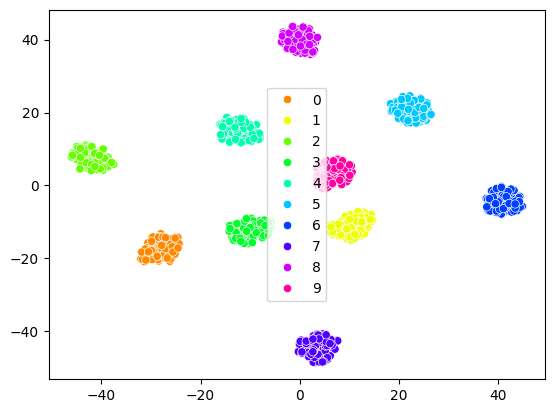

In [14]:
sns.scatterplot(x=Zs[:, 0], y=Zs[:, 1], hue=labels, 
                palette=sns.color_palette("hsv", 10))